In [2]:
%matplotlib inline
import cmlreaders as cml
import pandas_to_pybeh as pb
import numpy as np
import seaborn as sb
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
sel_sub = pd.DataFrame([])
master = pd.read_excel('220302_all_neuropsych.xlsx',engine="openpyxl") #read master spreadsheet of all RAM subjects demo/neuropsych data

sub_mat=list(np.zeros(len(master))*np.nan )
df = cml.get_data_index('r1')

for sub in df['subject'].unique():
    num = int(sub[2:5])
    for i in master.index:
        sel = master.iloc[i]['Subject Number']
        if sel == num:
            sub_mat[i]=sub

master['subject']=sub_mat
master = master.dropna(subset=['BAI','BDI'])

In [4]:
master.columns

Index(['Subject Number', 'Study site', 'Gender', 'Years of Education',
       'Age of seizure onset', 'Age at Implant (calculated)',
       'Phase II Implant Date', 'Phase III Implant Date ',
       'Traumatic Brain Injury (TBI) Notes', 'Date of Pre-operative Report',
       'BAI', 'BDI', 'PHQ-9', 'GAD-7', 'FSIQ4', 'FSIQ3',
       'FSIQ2 (Four Subtest)', 'FSIQ2 (Two Subtest)', 'FSIQ1 (Four Subtest)',
       'FSIQ1 (Two Subtest)', 'GAI', 'VCI', 'PRI', 'WMI',
       'Pre-operative Report',
       'Prior Neurosurgical Procedures (can select more than one)',
       'Prior Surgery: Resection Detail', 'Prior Surgery: Callosotomy Detail',
       'Prior Surgery: Laser Ablation Detail', 'subject'],
      dtype='object')

In [5]:
BAI_low = 5
BAI_high = 13
BDI_low = 5
BDI_high = 13

In [6]:
master['BAI_bin'] = 'mid'
master.loc[master['BAI'] > BAI_high, 'BAI_bin'] = 'high'
master.loc[master['BAI'] < BAI_low, 'BAI_bin'] = 'low'

master['BDI_bin'] = 'mid'
master.loc[master['BDI'] > BDI_high, 'BDI_bin'] = 'high'
master.loc[master['BDI'] < BDI_low, 'BDI_bin'] = 'low'

master

In [7]:
all_fr1_events = cml.CMLReader.load_events(experiments=["FR1"])
# all_catfr1_events = cml.CMLReader.load_events(experiments=["catFR1"], data_type='task_events')

In [8]:
all_fr1_events_neuropsych = all_fr1_events.merge(master, on='subject')
# all_catfr1_events_neuropsych = all_catfr1_events.merge(master, on='subject')

In [9]:
events = all_fr1_events_neuropsych.query('type == ["WORD", "REC_WORD"]')
# events = all_catfr1_events_neuropsych.query('type == ["WORD", "REC_WORD"]')
events.rename(columns={'item_name': 'item'}, inplace=True)
events = events[events['list'] > 0]
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')
ELIs = rec_evs[rec_evs['intrusion']==-1]
PLIs = rec_evs[rec_evs['intrusion']>0]

# removing subjects who were presented with the same word multiple times (probably repeated data)
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num']).size().to_frame(name='n').reset_index()
bad_lists = n_word_pres.query('n > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()
# bad_subs = bad_subs + ["R1171M", "R1093J", "R1329T", "R1341T", "R1015J"] #"R1015J" had no recalls, other subjects unsure...
# events.query('subject not in @bad_subs', inplace=True)

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
#Load in emotionality ratings from csv
emot_df = pd.read_csv('BRM-emot.csv')
emot_df['Word'] = emot_df['Word'].str.upper()
emot_df

,Unnamed: 0,Word,V.Mean.Sum,V.SD.Sum,V.Rat.Sum,A.Mean.Sum,A.SD.Sum,A.Rat.Sum,D.Mean.Sum,D.SD.Sum,...,A.Rat.L,A.Mean.H,A.SD.H,A.Rat.H,D.Mean.L,D.SD.L,D.Rat.L,D.Mean.H,D.SD.H,D.Rat.H
0,1,AARDVARK,6.26,2.21,19,2.41,1.40,22,4.27,1.75,...,11,2.55,1.29,11,4.12,1.64,8,4.43,1.99,7
1,2,ABALONE,5.30,1.59,20,2.65,1.90,20,4.95,1.79,...,12,2.38,1.92,8,5.55,2.21,11,4.36,1.03,11
2,3,ABANDON,2.84,1.54,19,3.73,2.43,22,3.32,2.50,...,11,3.82,2.14,11,2.77,2.09,13,4.11,2.93,9
3,4,ABANDONMENT,2.63,1.74,19,4.95,2.64,21,2.64,1.81,...,14,5.29,2.63,7,2.31,1.45,16,3.08,2.19,12
4,5,ABBEY,5.85,1.69,20,2.20,1.70,20,5.00,2.02,...,9,2.55,1.92,11,4.83,2.18,18,5.43,1.62,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13910,13911,ZONE,4.75,2.05,20,3.78,2.53,18,5.23,1.82,...,9,4.89,1.76,9,5.09,1.81,11,5.36,1.91,11
13911,13912,ZONING,4.65,1.60,20,3.77,1.95,22,4.47,2.20,...,12,3.70,1.57,10,5.17,2.32,6,4.15,2.15,13
13912,13913,ZOO,7.00,1.58,21,5.63,2.54,19,6.33,2.56,...,13,5.17,2.14,6,5.67,2.87,12,7.22,1.86,9
13913,13914,ZOOM,5.86,1.53,21,5.68,2.54,19,5.90,2.17,...,8,6.27,2.45,11,6.00,2.12,9,5.83,2.29,12


In [11]:
emot_df[emot_df['Word']=='ASH']

,Unnamed: 0,Word,V.Mean.Sum,V.SD.Sum,V.Rat.Sum,A.Mean.Sum,A.SD.Sum,A.Rat.Sum,D.Mean.Sum,D.SD.Sum,...,A.Rat.L,A.Mean.H,A.SD.H,A.Rat.H,D.Mean.L,D.SD.L,D.Rat.L,D.Mean.H,D.SD.H,D.Rat.H


In [12]:
v_mean = []
a_mean = []
d_mean = []
for i in PLIs['item']:
    try:
        if emot_df['Word'].str.contains(i).any() & len(emot_df[emot_df['Word']==i]==1): 
            v_mean.append(emot_df[emot_df['Word']==i]['V.Mean.Sum'].item())
            a_mean.append(emot_df[emot_df['Word']==i]['A.Mean.Sum'].item())
            d_mean.append(emot_df[emot_df['Word']==i]['D.Mean.Sum'].item())
        else:
            v_mean.append(np.nan)
            a_mean.append(np.nan)
            d_mean.append(np.nan)
    except:
        print(i)
PLIs['v_mean']=v_mean
PLIs['a_mean']=a_mean
PLIs['d_mean']=d_mean
PLIs = PLIs.dropna(subset=['v_mean'])
PLIs = PLIs.reset_index(drop=True)
PLIs

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,answer,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,iscorrect,item,item_num,...,Pre-operative Report,Prior Neurosurgical Procedures (can select more than one),Prior Surgery: Resection Detail,Prior Surgery: Callosotomy Detail,Prior Surgery: Laser Ablation Detail,BAI_bin,BDI_bin,v_mean,a_mean,d_mean
0,-999,R1001P_FR1_0_12Oct14_1034,472388,1.02,FR1,1,0,-999,CLOUD,58,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,6.20,2.81,4.79
1,-999,R1001P_FR1_0_12Oct14_1034,481339,1.02,FR1,1,0,-999,CLOUD,58,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,6.20,2.81,4.79
2,-999,R1001P_FR1_0_12Oct14_1034,526358,1.02,FR1,1,0,-999,SHEET,217,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,5.57,2.64,5.00
3,-999,R1001P_FR1_0_12Oct14_1034,574411,1.02,FR1,1,0,-999,SCHOOL,210,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,5.41,4.57,5.88
4,-999,R1001P_FR1_0_12Oct14_1034,921980,1.02,FR1,1,0,-999,BENCH,20,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,5.50,3.46,5.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,-999,R1542J_FR1_5_24Feb21_1621.h5,1159412,,FR1,2,0,-999,PLATE,182,...,BradenPierson_01.19.2021.pdf,VNS implant,NaN,NaN,NaN,low,mid,4.80,3.18,5.79
1879,-999,R1572T_FR1_0_26Jul21_1124,751259,1.05,FR1,2,0,-999,PIG,183,...,1572.docx,NaN,NaN,NaN,NaN,mid,mid,4.83,3.68,5.04
1880,-999,R1572T_FR1_0_26Jul21_1124,754936,1.05,FR1,1,0,-999,DOOR,79,...,1572.docx,NaN,NaN,NaN,NaN,mid,mid,5.43,3.19,6.10
1881,-999,R1572T_FR1_0_26Jul21_1124,759747,1.05,FR1,1,0,-999,BATH,13,...,1572.docx,NaN,NaN,NaN,NaN,mid,mid,7.00,3.25,6.64


In [13]:
v_mean = []
a_mean = []
d_mean = []
for i in ELIs['item']:
    try:
        if emot_df['Word'].str.contains(i).any() & len(emot_df[emot_df['Word']==i]==1): 
            v_mean.append(emot_df[emot_df['Word']==i]['V.Mean.Sum'].item())
            a_mean.append(emot_df[emot_df['Word']==i]['A.Mean.Sum'].item())
            d_mean.append(emot_df[emot_df['Word']==i]['D.Mean.Sum'].item())
        else:
            v_mean.append(np.nan)
            a_mean.append(np.nan)
            d_mean.append(np.nan)
    except:
        print(i)
ELIs['v_mean']=v_mean
ELIs['a_mean']=a_mean
ELIs['d_mean']=d_mean
ELIs = ELIs.dropna(subset=['v_mean'])
ELIs = ELIs.reset_index(drop=True)
ELIs

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,answer,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,iscorrect,item,item_num,...,Pre-operative Report,Prior Neurosurgical Procedures (can select more than one),Prior Surgery: Resection Detail,Prior Surgery: Callosotomy Detail,Prior Surgery: Laser Ablation Detail,BAI_bin,BDI_bin,v_mean,a_mean,d_mean
0,-999,R1001P_FR1_0_12Oct14_1034,519111,1.02,FR1,-1,0,-999,BEACH,14,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,7.21,5.10,5.70
1,-999,R1001P_FR1_0_12Oct14_1034,519766,1.02,FR1,-1,0,-999,GOD,-1,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,5.90,5.56,5.00
2,-999,R1001P_FR1_0_12Oct14_1034,530085,1.02,FR1,-1,0,-999,CLOVE,-1,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,5.53,3.32,5.54
3,-999,R1001P_FR1_0_12Oct14_1034,570811,1.02,FR1,-1,0,-999,COW,65,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,5.42,2.95,5.24
4,-999,R1001P_FR1_0_12Oct14_1034,573878,1.02,FR1,-1,0,-999,CLOTHES,-1,...,REP001_neurospych.pdf,NaN,NaN,NaN,NaN,mid,low,6.77,3.14,5.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,-999,R1542J_FR1_5_24Feb21_1621.h5,1357296,,FR1,-1,0,-999,HORSE,-1,...,BradenPierson_01.19.2021.pdf,VNS implant,NaN,NaN,NaN,low,mid,6.05,4.16,5.71
1795,-999,R1572T_FR1_0_26Jul21_1124,452173,1.05,FR1,-1,0,-999,PIG,183,...,1572.docx,NaN,NaN,NaN,NaN,mid,mid,4.83,3.68,5.04
1796,-999,R1572T_FR1_0_26Jul21_1124,457098,1.05,FR1,-1,0,-999,CAR,44,...,1572.docx,NaN,NaN,NaN,NaN,mid,mid,6.63,4.04,6.41
1797,-999,R1572T_FR1_0_26Jul21_1124,546637,1.05,FR1,-1,0,-999,DOG,77,...,1572.docx,NaN,NaN,NaN,NaN,mid,mid,7.00,5.43,5.73


In [14]:
sub_PLI_df = pd.DataFrame([])
for sub in PLIs['subject'].unique():
    sub_v = np.mean(PLIs[PLIs['subject']==sub]['v_mean'])
    sub_a = np.mean(PLIs[PLIs['subject']==sub]['a_mean'])
    sub_d = np.mean(PLIs[PLIs['subject']==sub]['d_mean'])
    sub_PLI_df = sub_PLI_df.append({
        'subject':sub,
        'BAI_bin':PLIs[PLIs['subject']==sub].iloc[0]['BAI_bin'],
        'BDI_bin':PLIs[PLIs['subject']==sub].iloc[0]['BDI_bin'],
        'sub_v':sub_v,
        'sub_a':sub_a,
        'sub_d':sub_d
    }, ignore_index=True)
sub_PLI_df

,BAI_bin,BDI_bin,sub_a,sub_d,sub_v,subject
0,mid,low,3.613571,5.403810,5.786905,R1001P
1,mid,low,3.220909,5.589091,5.276364,R1002P
2,mid,mid,3.573750,5.764583,6.166667,R1006P
3,low,low,4.115556,5.465000,5.310556,R1010J
4,low,low,3.557857,5.229286,6.200000,R1018P
...,...,...,...,...,...,...
81,mid,low,3.958750,5.500000,5.093333,R1443D
82,mid,low,3.491818,5.373636,5.618182,R1457T
83,high,high,3.652000,5.786000,5.026000,R1466J
84,low,mid,3.443750,5.783750,5.876250,R1542J


In [15]:
sub_ELI_df = pd.DataFrame([])
for sub in ELIs['subject'].unique():
    sub_v = np.mean(ELIs[ELIs['subject']==sub]['v_mean'])
    sub_a = np.mean(ELIs[ELIs['subject']==sub]['a_mean'])
    sub_d = np.mean(ELIs[ELIs['subject']==sub]['d_mean'])
    sub_ELI_df = sub_ELI_df.append({
        'subject':sub,
        'BAI_bin':ELIs[ELIs['subject']==sub].iloc[0]['BAI_bin'],
        'BDI_bin':ELIs[ELIs['subject']==sub].iloc[0]['BDI_bin'],
        'sub_v':sub_v,
        'sub_a':sub_a,
        'sub_d':sub_d
    }, ignore_index=True)
sub_ELI_df

,BAI_bin,BDI_bin,sub_a,sub_d,sub_v,subject
0,mid,low,3.660263,5.600263,5.776842,R1001P
1,mid,low,3.904000,5.132000,5.004000,R1002P
2,mid,mid,3.878125,5.598750,5.686250,R1006P
3,low,low,3.956667,5.346667,5.693333,R1010J
4,low,low,3.385000,5.790000,5.945000,R1018P
...,...,...,...,...,...,...
79,mid,low,3.614595,5.645676,5.700270,R1443D
80,mid,low,3.806667,5.439444,5.993889,R1457T
81,high,high,3.768462,5.533846,6.003077,R1466J
82,low,mid,3.456875,5.627500,5.566250,R1542J


p = 0.0011805263450155644 t = -3.4252564069269336  N_low = 30  N_high = 26


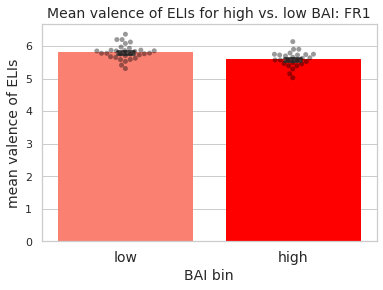

In [19]:
#valence of high/low PLIs grouped by subject
met = 'BAI'
sub_df = sub_PLI_df
N_low = len(sub_df[sub_df['BAI_bin']=='low'])
N_high = len(sub_df[sub_df['BAI_bin']=='high'])
plt.figure()
sb.set(style="whitegrid")
ax=sb.barplot(x='BAI_bin', y='sub_v', data=sub_df, order=['low', 'high'], ci=68,capsize=0.1)
if met=='BAI':
    ax.patches[0].set_color('salmon')
    ax.patches[1].set_color('red')
else:
    ax.patches[0].set_color('cornflowerblue')
    ax.patches[1].set_color('darkblue')
sb.swarmplot(x='BAI_bin', y='sub_v', data=sub_df, order=['low', 'high'], color="0",alpha=.4)
plt.ylabel('mean valence of ELIs',fontsize=14)
plt.xlabel('BAI bin',fontsize=14)
plt.xticks(fontsize=14)
plt.title('Mean valence of ELIs for high vs. low BAI: FR1',fontsize=14)
t = stats.ttest_ind(sub_df[sub_df['BAI_bin']=='high']['sub_v'], sub_df[sub_df['BAI_bin']=='low']['sub_v'])
p = t.pvalue
t_s = t.statistic
print('p =',p,'t =',t_s,' N_low =', N_low, ' N_high =', N_high)
plt.savefig('Valence of ELIs, FR1, BAI.pdf')
# plt.text(0, 0, 'Low N=%.0f, High N=%.0f, p=%.3f '%(N_low, N_high ,p),fontsize=12)

In [17]:
t

Ttest_indResult(statistic=0.1385301471998299, pvalue=0.8903464627673634)

p = 0.8232685433793968  N_low = 30  N_high = 26


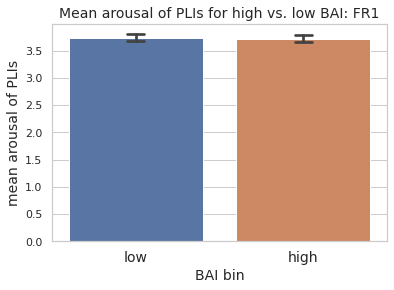

In [18]:
#arousal of high/low PLIs grouped by subject
sub_df = sub_PLI_df
N_low = len(sub_df[sub_df['BAI_bin']=='low'])
N_high = len(sub_df[sub_df['BAI_bin']=='high'])
plt.figure()
sb.set(style="whitegrid")
ax=sb.barplot(x='BAI_bin', y='sub_a', data=sub_df, order=['low', 'high'], ci=68,capsize=0.1)
# sb.swarmplot(x='BAI_bin', y=v_mean, data=PLIs, order=['low', 'high'], color="0",alpha=.4)
plt.ylabel('mean arousal of PLIs',fontsize=14)
plt.xlabel('BAI bin',fontsize=14)
plt.xticks(fontsize=14)
plt.title('Mean arousal of PLIs for high vs. low BAI: FR1',fontsize=14)
t = stats.ttest_ind(sub_df[sub_df['BAI_bin']=='high']['sub_a'], sub_df[sub_df['BAI_bin']=='low']['sub_a'])
p = t.pvalue
print('p =',p,' N_low =', N_low, ' N_high =', N_high)
# plt.savefig('Arousal of PLIs, FR1, BAI.pdf')
# plt.text(0, 0, 'Low N=%.0f, High N=%.0f, p=%.3f '%(N_low, N_high ,p),fontsize=12)

p = 0.9209549513112845  N_low = 30  N_high = 25


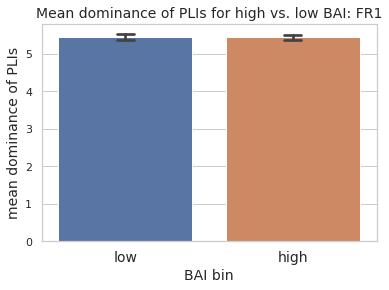

In [187]:
#dominance of high/low PLIs grouped by subject
sub_df = sub_ELI_df
N_low = len(sub_df[sub_df['BAI_bin']=='low'])
N_high = len(sub_df[sub_df['BAI_bin']=='high'])
plt.figure()
sb.set(style="whitegrid")
ax=sb.barplot(x='BAI_bin', y='sub_d', data=sub_df, order=['low', 'high'], ci=68,capsize=0.1)
# sb.swarmplot(x='BAI_bin', y=v_mean, data=PLIs, order=['low', 'high'], color="0",alpha=.4)
plt.ylabel('mean dominance of PLIs',fontsize=14)
plt.xlabel('BAI bin',fontsize=14)
plt.xticks(fontsize=14)
plt.title('Mean dominance of PLIs for high vs. low BAI: FR1',fontsize=14)
t = stats.ttest_ind(sub_df[sub_df['BAI_bin']=='high']['sub_d'], sub_df[sub_df['BAI_bin']=='low']['sub_d'])
p = t.pvalue
print('p =',p,' N_low =', N_low, ' N_high =', N_high)
# plt.savefig('Dominance of PLIs, FR1, BAI.pdf')
# plt.text(0, 0, 'Low N=%.0f, High N=%.0f, p=%.3f '%(N_low, N_high ,p),fontsize=12)

p = 0.057945383344466125 t = -1.9389301620761292  N_low = 28  N_high = 26


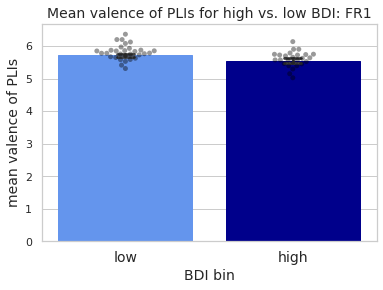

In [202]:
#valence of high/low ELIs grouped by subject
met = 'BDI'
sub_df = sub_PLI_df
N_low = len(sub_df[sub_df['BDI_bin']=='low'])
N_high = len(sub_df[sub_df['BDI_bin']=='high'])
plt.figure()
sb.set(style="whitegrid")
ax=sb.barplot(x='BDI_bin', y='sub_v', data=sub_df, order=['low', 'high'], ci=68,capsize=0.1)
if met=='BAI':
    ax.patches[0].set_color('salmon')
    ax.patches[1].set_color('red')
else:
    ax.patches[0].set_color('cornflowerblue')
    ax.patches[1].set_color('darkblue')
sb.swarmplot(x='BAI_bin', y='sub_v', data=sub_df, order=['low', 'high'], color="0",alpha=.4)
plt.ylabel('mean valence of PLIs',fontsize=14)
plt.xlabel('BDI bin',fontsize=14)
plt.xticks(fontsize=14)
plt.title('Mean valence of PLIs for high vs. low BDI: FR1',fontsize=14)
t = stats.ttest_ind(sub_df[sub_df['BDI_bin']=='high']['sub_v'], sub_df[sub_df['BDI_bin']=='low']['sub_v'])
p = t.pvalue
t_s = t.statistic
print('p =',p,'t =',t_s,' N_low =', N_low, ' N_high =', N_high)
plt.savefig('Valence of PLIs, FR1, BDI.pdf')
# plt.text(0, 0, 'Low N=%.0f, High N=%.0f, p=%.3f '%(N_low, N_high ,p),fontsize=12)

p = 0.025625143620797357  N_low = 468  N_high = 819


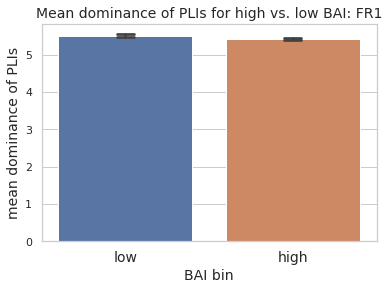

In [118]:
N_low = len(PLIs[PLIs['BAI_bin']=='low'])
N_high = len(PLIs[PLIs['BAI_bin']=='high'])
plt.figure()
sb.set(style="whitegrid")
ax=sb.barplot(x='BAI_bin', y='d_mean', data=PLIs, order=['low', 'high'], ci=68,capsize=0.1)
# sb.swarmplot(x='BAI_bin', y=v_mean, data=PLIs, order=['low', 'high'], color="0",alpha=.4)
plt.ylabel('mean dominance of PLIs',fontsize=14)
plt.xlabel('BAI bin',fontsize=14)
plt.xticks(fontsize=14)
plt.title('Mean dominance of PLIs for high vs. low BAI: FR1',fontsize=14)
t = stats.ttest_ind(PLIs[PLIs['BAI_bin']=='high']['d_mean'], PLIs[PLIs['BAI_bin']=='low']['d_mean'])
p = t.pvalue
# plt.savefig('Dominance of PLIs, FR1, BAI.pdf')
t_s = t.statistic
print('p =',p,'t =',t_s,' N_low =', N_low, ' N_high =', N_high)
# plt.text(0, 0, 'Low N=%.0f, High N=%.0f, p=%.3f '%(N_low, N_high ,p),fontsize=12)

In [ ]:
t_sub = PLIs.groupby('subject')

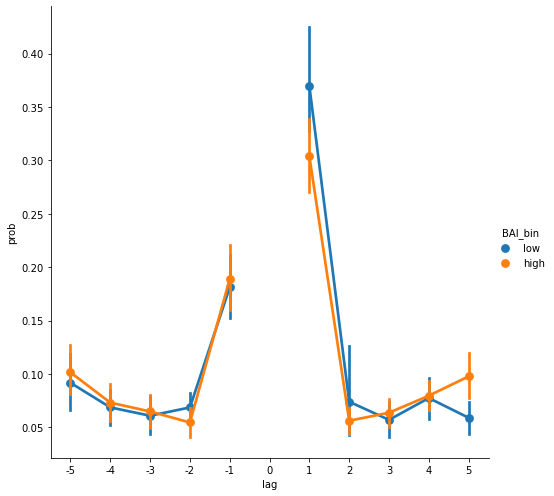

In [14]:
g = sns.catplot(x='lag', y='prob', kind='point', hue='BAI_bin', hue_order=['low', 'high'], height = 7,
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )
# plt.savefig('BAI_lagCRP.pdf')

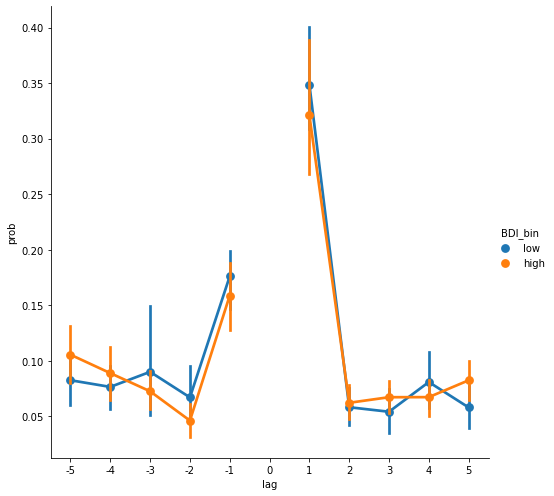

In [15]:
g = sns.catplot(x='lag', y='prob', kind='point', hue='BDI_bin', hue_order=['low', 'high'], height = 7,
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )
# plt.savefig('BDI_lagCRP.pdf')

In [16]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)
item_num_df

,item_num,item
0,0,CORKSCREW
1,1,KNIFE
2,2,CHERRY
3,3,BLUEBERRY
4,4,SCOOTER
...,...,...
307,307,SUEDE
308,308,VELVET
309,309,SPANDEX
310,310,LINEN


In [21]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [22]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [23]:
# get all pairs of items
items = item_num_df.item.values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['item_1', 'item_2']).to_frame(index=False)

In [24]:
sem_sim_df

,item_1,item_2
0,CORKSCREW,CORKSCREW
1,CORKSCREW,KNIFE
2,CORKSCREW,CHERRY
3,CORKSCREW,BLUEBERRY
4,CORKSCREW,SCOOTER
...,...,...
97339,SATIN,SUEDE
97340,SATIN,VELVET
97341,SATIN,SPANDEX
97342,SATIN,LINEN


In [25]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='item_1', 
               col2='item_2', 
               keyed_vector=word2vec_vectors)

In [26]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='item_1', right_on='item').merge(
    item_num_df, left_on='item_2', right_on='item', suffixes=('_1', '_2')).drop(columns=['item_1', 'item_2'])

In [27]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [28]:
pb_sem_crp = events_new.groupby(['subject', 'BAI_bin', 'BDI_bin']).apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

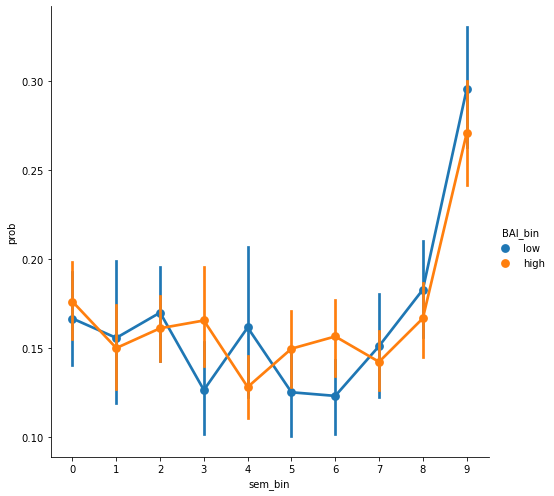

In [29]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', hue='BAI_bin', hue_order=['low', 'high'], height = 7,
                  data=pb_sem_crp
           )
# fig = g.figure.savefig('BAI_semCRP')
plt.savefig('BAI_semCRP.pdf')

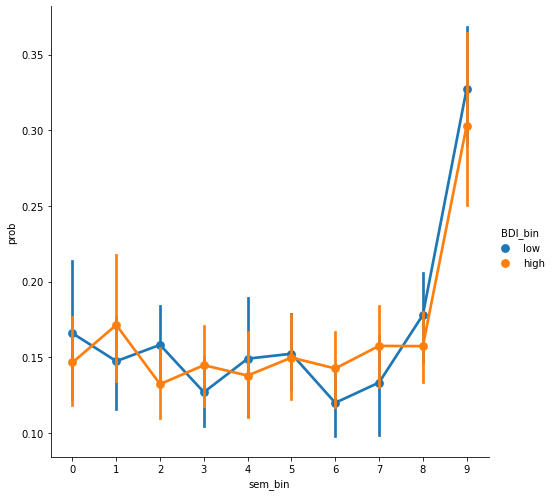

In [30]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', hue='BDI_bin', hue_order=['low', 'high'], height = 7,
                  data=pb_sem_crp
           )
plt.savefig('BDI_semCRP.pdf')

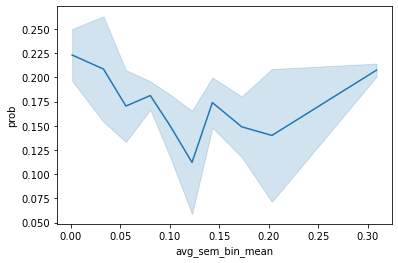

In [22]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp)

In [31]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False,
                                                       ).reset_index()

pb_sem_dist_fact

,subject,0
0,R1111M,0.490093
1,R1409D,0.405333
